## Importación de paquetes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor
import matplotlib

from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify, Symbol,hessian, acos)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import ReferenceFrame, Point, LagrangesMethod
from sympy import legendre_poly

from functools import lru_cache

## Inicializar espacio de trabajo

In [2]:
init_vprinting()

In [3]:
x, t = symbols('x t')

## Matrices de Derivación y Barycentric coordinates

In [4]:
from optibot.pseudospectral import (base_points, coll_points, matrix_D_bary, bary_poly, LG_end_p_fun,
                                    LG_diff_end_p_fun, dynamic_error_pseudospectral, lagrangePolynomial)

In [5]:
from optibot.pseudospectral import LG_end_p_fun_cas, LG_diff_end_p_fun_cas

In [6]:
from optibot.casadi import sympy2casadi

In [7]:
import time

## Problema de ejemplo: bloque que desliza

$$\dot x_1 = x_2$$
$$\dot x_2 = u $$

Minimizar $t_f$ sujeto a:

$t_0 = 0\$

$x_2(0) = x_2(t_f) = 0$

$x_1(0) = 0\ ,\ x_1(t_f) = 1$

$ u_{min} < u(t) < u_{max}$

#### LGL: función objetivo alternativa

$u(\tau)$ está definida como el polinomio de grado N-1 que pasa por los N valores calculados de $U^N$. Encontrar cómo obtener $\int_{-1}^{1}{u(\tau)^2}$ en función de $U^N$

In [8]:
def obj_f_u_LGL(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LGL(N, precission), coefs)
    res = integrate(pol_lag ** 2, [x, -1, 1])
    return lambdify(coefs, res)

def obj_f_u_LG2(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG(N, precission), coefs)
    res = integrate(pol_lag ** 2, [x, -1, 1])
    return lambdify(coefs, res)

### Formulación clásica $\dot x = f(x,u)$

In [9]:
import casadi as cas

In [10]:
x_sym = cas.SX.sym('x', 2)
x_dot_sym = cas.SX.sym('x_dot', 2)
u_sym = cas.SX.sym('u',1)

dynam_f_x = cas.Function(
    "dynamics_x",
    [x_sym, x_dot_sym, u_sym],
    [x_dot_sym[1]-u_sym]
)

In [11]:
N = 7
opti = cas.Opti()
opti.solver('ipopt')

In [12]:
x_opti = opti.variable(N, 2)
u_opti = opti.variable(N)
tau_arr = base_points(N, 'LGL', 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [13]:
D_mat = sympy2casadi(matrix_D_bary(N, 'LGL',20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LGL(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [14]:
opti.subject_to(x_opti[0,:].T == [0., 0.])
opti.subject_to(x_opti[-1,:].T == [1. ,0.])
opti.subject_to(t_f > 0)

for ii in range(N):
    opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:])==0)
    opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0])
    opti.subject_to(u_opti[ii] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [15]:
solve_repetitions = 10
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_LGL = (cput1-cput0)/solve_repetitions


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      130
Number of nonzeros in inequality constraint Jacobian.:       15
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:       22
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

In [16]:
xx_sol_LGL = sol.value(x_opti)
uu_sol_LGL = sol.value(u_opti)
t_f_LGL = sol.value(t_f)

t_arr_LGL = t_0 + (1 + np.array(tau_arr))*(t_f_LGL - t_0)/2

q_pol_LGL = bary_poly(t_arr_LGL, xx_sol_LGL[:,0])
v_pol_LGL = bary_poly(t_arr_LGL, xx_sol_LGL[:,1])
u_pol_LGL = bary_poly(t_arr_LGL, uu_sol_LGL[:])

In [17]:
t_arr_LGL

array([0.0, 0.17693728405263238630, 0.55355524036982750399,
       1.04218014298967, 1.5308050456095151378, 1.9074230019267102555,
       2.0843602859793426], dtype=object)

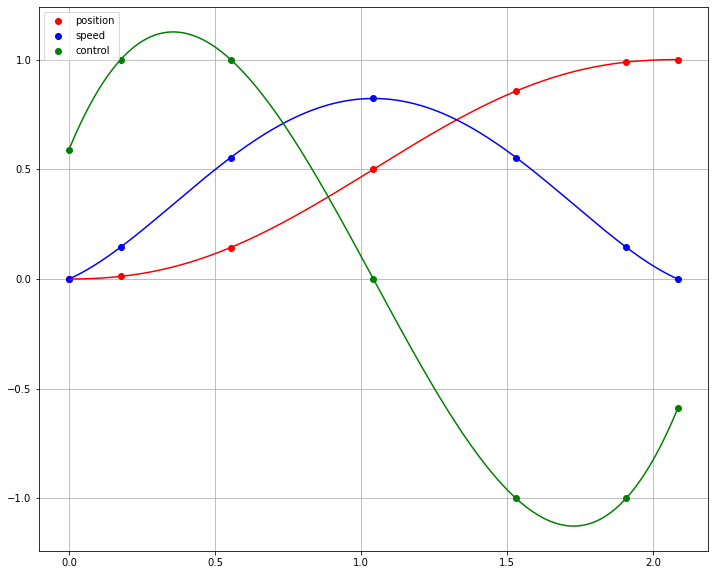

In [18]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_LGL, xx_sol_LGL[:,0], 'ro', label = 'position')
plt.plot(t_arr_LGL, xx_sol_LGL[:,1], 'bo', label = 'speed')
plt.plot(t_arr_LGL, uu_sol_LGL[:], 'go', label = 'control')
N_interp = 300
t_int_arr_LGL = np.linspace(t_0, t_f_LGL, N_interp)
plt.plot(t_int_arr_LGL, q_pol_LGL(t_int_arr_LGL), 'r')
plt.plot(t_int_arr_LGL, v_pol_LGL(t_int_arr_LGL), 'b')
plt.plot(t_int_arr_LGL, u_pol_LGL(t_int_arr_LGL), 'g')
plt.grid()
plt.legend()

In [19]:
#u_sq_LGL = u_interp_f_LGL(t_int_arr)**2
#quality_LGL = np.trapz(u_sq_LGL, t_int_arr)
quality_LGL = t_f_LGL
quality_LGL

In [20]:
cpudt_LGL*1000

trun_err_LGL = error_transcr(q_pol_LGL, v_pol_LGL, u_pol_LGL, t_0, t_f_LGL)
trun_err_LGL

### Formulación $D^2$ de Ross, Rea y Fahroo

In [21]:
q_sym = cas.SX.sym('q', 1)
q_dot_sym = cas.SX.sym('q_dot', 1)
q_dot_dot_sym = cas.SX.sym('q_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f_q = cas.Function(
    "dynamics",
    [q_sym, q_dot_sym, q_dot_dot_sym, u_sym],
    [q_dot_dot_sym-u_sym]
)

In [22]:
N = 9
opti = cas.Opti()
opti.solver('ipopt')

In [23]:
x_opti = opti.variable(N)
u_opti = opti.variable(N)
tau_arr = base_points(N, 'LGL', 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [24]:
D_mat = sympy2casadi(matrix_D_bary(N, 'D2',20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti
x_dot_dot_opti = (2/t_f - t_0) * D_mat@x_dot_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LGL(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [25]:
opti.subject_to(x_opti[0] == [0.])
opti.subject_to(x_opti[-1] == [1.])
opti.subject_to(x_dot_opti[0] == [0.])
opti.subject_to(x_dot_opti[-1] == [0.])
opti.subject_to(t_f > 0)

for ii in range(N):
    opti.subject_to(dynam_f_q(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii,:])==0)
    opti.subject_to(u_opti[ii] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [26]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_D2 = (cput1-cput0)/solve_repetitions

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      121
Number of nonzeros in inequality constraint Jacobian.:       19
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       13
Total number of inequality constraints...............:       19
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        9

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [27]:
xx_sol_D2 = sol.value(x_opti)
uu_sol_D2 = sol.value(u_opti)
vv_sol_D2 = sol.value(x_dot_opti)
t_f_D2 = sol.value(t_f)

t_arr_D2 = t_0 + (1 + np.array(tau_arr))*(t_f_D2 - t_0)/2

q_pol_D2 = lagrangePolynomial(t_arr_D2, xx_sol_D2[:])
v_pol_D2 = lagrangePolynomial(t_arr_D2, xx_sol_D2[:]).diff(x)
u_pol_D2 = lagrangePolynomial(t_arr_D2, uu_sol_D2[:])

q_interp_f_D2 = lambdify([x,],q_pol_D2)
v_interp_f_D2 = lambdify([x,],v_pol_D2)
u_interp_f_D2 = lambdify([x,],u_pol_D2)

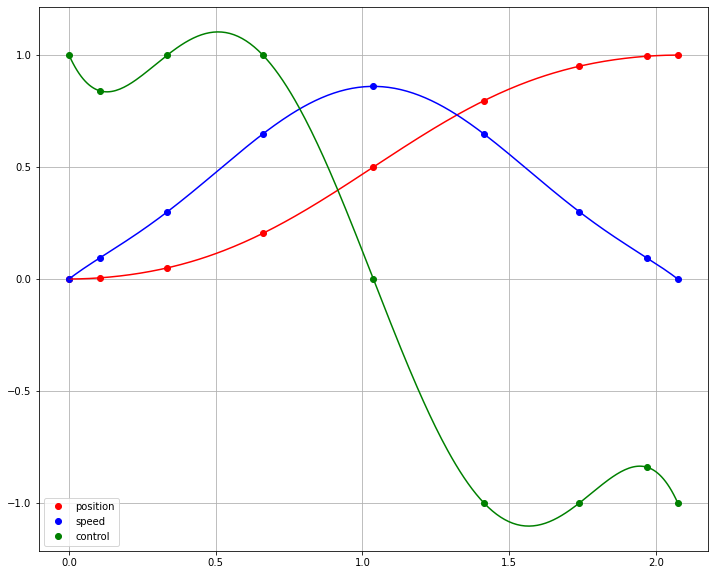

In [28]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_D2, xx_sol_D2[:], 'ro', label = 'position')
plt.plot(t_arr_D2, vv_sol_D2[:], 'bo', label = 'speed')
plt.plot(t_arr_D2, uu_sol_D2[:], 'go', label = 'control')
N_interp = 300
t_int_arr_D2 = np.linspace(t_0, t_f_D2, N_interp)
plt.plot(t_int_arr_D2, q_interp_f_D2(t_int_arr_D2), 'r')
plt.plot(t_int_arr_D2, v_interp_f_D2(t_int_arr_D2), 'b')
plt.plot(t_int_arr_D2, u_interp_f_D2(t_int_arr_D2), 'g')
plt.grid()
plt.legend()

In [29]:
#u_sq_D2 = u_interp_f_D2(t_int_arr)**2
#quality_D2 = np.trapz(u_sq_D2, t_int_arr)
quality_D2 = t_f_D2
quality_D2

In [30]:
cpudt_D2*1000

trun_err_D2 = error_transcr(q_pol_D2, v_pol_D2, u_pol_D2, t_0, t_f_D2)
trun_err_D2

## Nuevo esquema LG2

In [31]:
q_sym = cas.SX.sym('q', 1)
q_dot_sym = cas.SX.sym('q_dot', 1)
q_dot_dot_sym = cas.SX.sym('q_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f = cas.Function(
    "dynamics",
    [q_sym, q_dot_sym, q_dot_dot_sym, u_sym],
    [q_dot_dot_sym-u_sym]
)

In [32]:
N = 7
opti = cas.Opti()
opti.solver('ipopt')

In [33]:
x_opti = opti.variable(N+2)
u_opti = opti.variable(N)
tau_arr_LG2 = base_points(N+2, 'LG2', 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [34]:
D_mat = sympy2casadi(matrix_D_bary(N+2, "LG2",20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti
x_dot_dot_opti = (2/t_f - t_0) * D_mat@x_dot_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LG2(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [35]:
opti.subject_to(x_opti[0] == [0.])
opti.subject_to(x_opti[-1] == [1.])
opti.subject_to(x_dot_opti[0] == [0.])
opti.subject_to(x_dot_opti[-1] == [0.])
opti.subject_to(t_f > 0)

for ii in range(1, N+1):
    opti.subject_to(dynam_f_q(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii-1,:])==0)
    opti.subject_to(u_opti[ii-1] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii-1])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [36]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_LG2 = (cput1-cput0)/solve_repetitions

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       99
Number of nonzeros in inequality constraint Jacobian.:       15
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:       17
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       11
Total number of inequality constraints...............:       15
        inequality constraints with only lower bounds:        8
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [37]:
xx_sol_LG2 = sol.value(x_opti)
uu_sol_LG2 = sol.value(u_opti)
vv_sol_LG2 = sol.value(x_dot_opti)
t_f_LG2 = sol.value(t_f)

t_arr_LG2 = t_0 + (1 + np.array(tau_arr_LG2))*(t_f_LG2 - t_0)/2
coll_p_t = t_0 + (1 + np.array(coll_points(N, 'LG2')))*(t_f_LG2 - t_0)/2

q_pol_LG2 = lagrangePolynomial(t_arr_LG2, xx_sol_LG2[:])
v_pol_LG2 = lagrangePolynomial(t_arr_LG2, xx_sol_LG2[:]).diff(x)
u_pol_LG2 = lagrangePolynomial(coll_p_t, uu_sol_LG2[:])

q_interp_f_LG2 = lambdify([x,],q_pol_LG2)
v_interp_f_LG2 = lambdify([x,],v_pol_LG2)
u_interp_f_LG2 = lambdify([x,],u_pol_LG2)

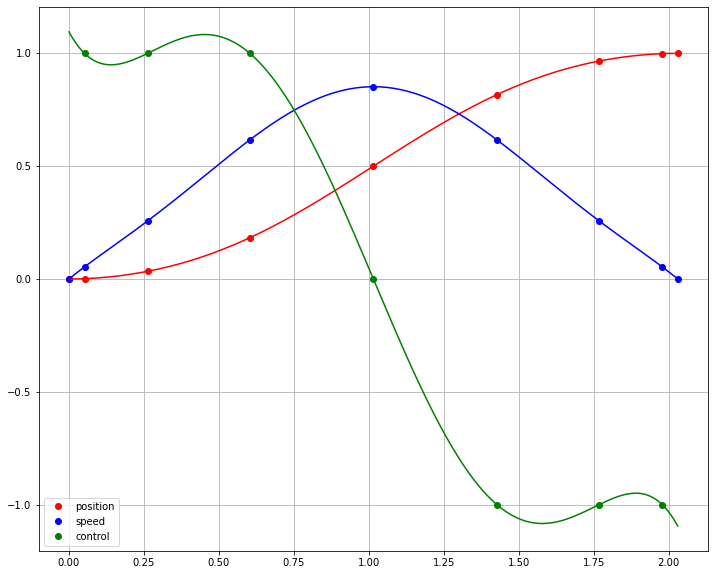

In [38]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_LG2, xx_sol_LG2[:], 'ro', label = 'position')
plt.plot(t_arr_LG2, vv_sol_LG2[:], 'bo', label = 'speed')
plt.plot(coll_p_t, uu_sol_LG2[:], 'go', label = 'control')
N_interp = 300
t_int_arr_LG2 = np.linspace(t_0, t_f_LG2, N_interp)
plt.plot(t_int_arr_LG2, q_interp_f_LG2(t_int_arr_LG2), 'r')
plt.plot(t_int_arr_LG2, v_interp_f_LG2(t_int_arr_LG2), 'b')
plt.plot(t_int_arr_LG2, u_interp_f_LG2(t_int_arr_LG2), 'g')
plt.grid()
plt.legend()

In [39]:
#u_sq_LG2 = u_interp_f_LG2(t_int_arr)**2
#quality_LG2 = np.trapz(u_sq_LG2, t_int_arr)
quality_LG2 = t_f_LG2
quality_LG2

In [40]:
cpudt_LG2*1000

trun_err_LG2 = error_transcr(q_pol_LG2, v_pol_LG2, u_pol_LG2, t_0, t_f_LG2)
trun_err_LG2

## COMPARACIÓN DE RESULTADOS

from IPython.display import Markdown as md
md(f'''| | Usual LGL | $D^2$ | Nuevo LG2 |
| --- | --- | --- | --- |
| Coste a optimizar ($t_f$) | {round(quality_LGL,5)} | {round(quality_D2,5)} | {round(quality_LG2,5)} |
| Valor medio de $(U^N)^2$ | {round(np.mean(uu_sol_LGL**2),4)} | {round(np.mean(uu_sol_D2**2),4)} | {round(np.mean(uu_sol_LG2**2),4)} |
| CPU time (ms) | {round(cpudt_LGL*1000,4)} | {round(cpudt_D2*1000,4)} | {round(cpudt_LG2*1000,4)} |
| Integrated Truncation Error | {"{:.2e}".format(trun_err_LGL)} | {trun_err_D2} | {trun_err_LG2} |''')

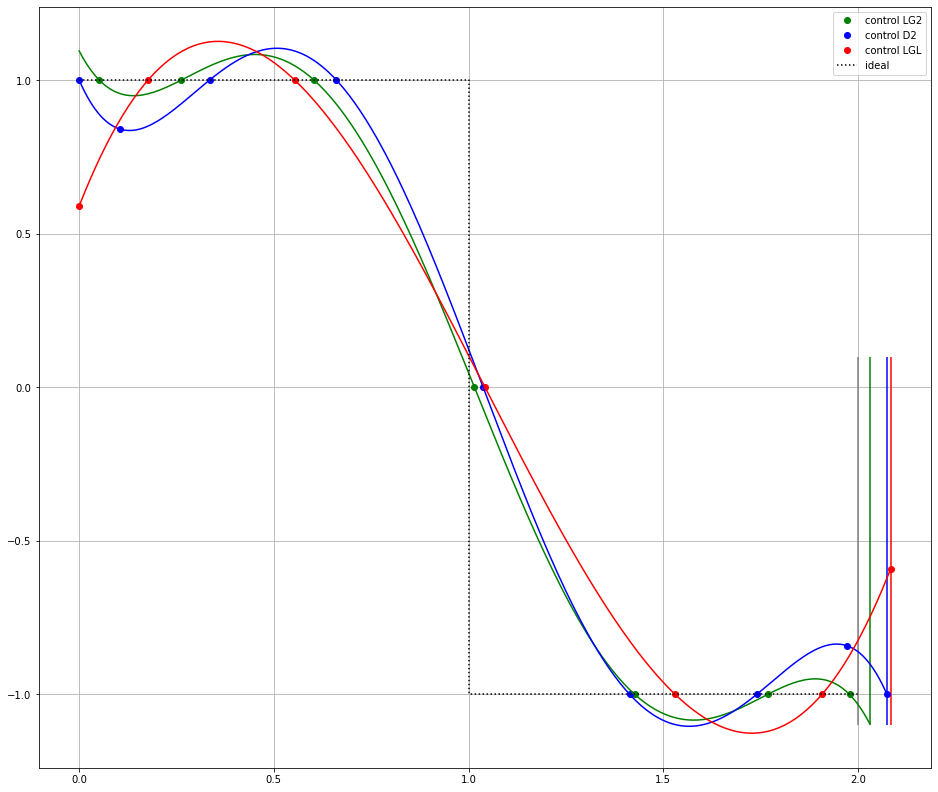

In [41]:
plt.figure(figsize=[16,14])

plt.plot(coll_p_t, uu_sol_LG2[:], 'go', label = 'control LG2')
plt.plot(t_arr_D2, uu_sol_D2[:], 'bo', label = 'control D2')
plt.plot(t_arr_LGL, uu_sol_LGL[:], 'ro', label = 'control LGL')

plt.plot(t_int_arr_LG2, u_interp_f_LG2(t_int_arr_LG2), 'g')
plt.plot(t_int_arr_D2, u_interp_f_D2(t_int_arr_D2), 'b')
plt.plot(t_int_arr_LGL, u_pol_LGL(t_int_arr_LGL), 'r')
plt.plot([0,1,1,2], [1,1,-1,-1], 'k:', label = 'ideal')
plt.vlines([2, t_f_LGL, t_f_D2, t_f_LG2], -1.1, 0.1, colors=['gray', 'r', 'b', 'g'] )
plt.grid()
plt.legend()

## Benchmarking de N y Convergencia

def opt_LGL_bloq_u(N):
    u_arr = np.zeros(N)
    u_arr[:N//2] = 1
    u_arr[-(N//2):] = -1
    return u_arr

In [42]:
def opti_setup(col_points = 7, scheme = 'LGL', precission = 20, M = 1, U_dim = 1):
    opti = cas.Opti()
    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    
    opt_dict = {
        'LGL': [col_points,],
        'D2': [col_points,],
        'LG2': [col_points+2,],
        'LGLm': [col_points+2,],
        'LG': [col_points+1,]
    }
    sch_options = opt_dict[scheme]
    N = sch_options[0]
    
    if scheme == 'LGL' or scheme == 'LG':
        x_opti = opti.variable(N, 2*M)
    else:
        x_opti = opti.variable(N, M)
    
    u_opti = opti.variable(col_points, U_dim)
    tau_arr = base_points(N, scheme, precission)
    return opti, N, x_opti, u_opti, tau_arr

def opti_start_point_constr(opti, scheme, x_opti, x_dot_opti, x_s, M=1):
    if scheme == 'LGL':
        opti.subject_to(x_opti[0,:].T == x_s)
    elif scheme == 'LG':
        opti.subject_to(x_opti[0,:].T == x_s)
    elif scheme == 'D2':
        opti.subject_to(x_opti[0,:] == x_s[:M])
        opti.subject_to(x_dot_opti[0,:] == x_s[M:])
    elif scheme == 'LG2':
        opti.subject_to(x_opti[0,:] == x_s[:M])
        opti.subject_to(x_dot_opti[0,:] == x_s[M:])
    elif scheme == 'LGLm':
        opti.subject_to(x_opti[0,:] == x_s[:M])
        opti.subject_to(x_dot_opti[0,:] == x_s[M:])
        
def opti_end_point_constr(opti, scheme, x_opti, x_dot_opti, N, x_f, precission = 20, M=1):
    if scheme == 'LGL':
        opti.subject_to(x_opti[-1,:].T == x_f)
    elif scheme == 'LG':
        endp_f = LG_end_p_fun_cas(N, precission)
        for ii in range(2*M):
            opti.subject_to(endp_f(x_opti[:,ii]) == x_f[ii])
    elif scheme == 'D2':
        opti.subject_to(x_opti[-1,:] == x_f[:M])
        opti.subject_to(x_dot_opti[-1,:] == x_f[M:])
    elif scheme == 'LG2':
        opti.subject_to(x_opti[-1,:] == x_f[:M])
        opti.subject_to(x_dot_opti[-1,:] == x_f[M:])
    elif scheme == 'LGLm':
        opti.subject_to(x_opti[-1,:] == x_f[:M])
        opti.subject_to(x_dot_opti[-1,:] == x_f[M:])
        
def opti_col_point_constr(opti, scheme, x_opti, x_dot_opti, x_dot_dot_opti, u_opti, 
                          dynam_f_x, dynam_f_q, N, M=1):
    if scheme == 'LGL':
        for ii in range(N):
            opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:])==0)
            opti.subject_to(x_opti[ii,M:] == x_dot_opti[ii,:M]) 
    if scheme == 'LG':
        #opti.subject_to(x_opti[0,1] == x_dot_opti[0,0]) #convert starting into semicollocation point
        for ii in range(1, N):
            opti.subject_to(dynam_f_x(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii-1,:])==0)
            opti.subject_to(x_opti[ii,M:] == x_dot_opti[ii,:M])
    elif scheme == 'D2':
        for ii in range(N):
            opti.subject_to(dynam_f_q(x_opti[ii,:], x_dot_opti[ii,:], x_dot_dot_opti[ii,:], u_opti[ii,:])==0)
    elif scheme == 'LG2':
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q(x_opti[ii,:], x_dot_opti[ii,:], x_dot_dot_opti[ii,:], u_opti[ii-1,:])==0)
    elif scheme == 'LGLm':
        for ii in range(1, N-1):
            opti.subject_to(dynam_f_q(x_opti[ii,:], x_dot_opti[ii,:], x_dot_dot_opti[ii,:], u_opti[ii-1,:])==0)

def chrono_solve(opti, solve_repetitions):
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt

def chrono_solve_random_init(opti, solve_repetitions, u_opti, u_lim):
    cpudt = 0.
    err_count = 0
    if not (type(u_lim) == int or type(u_lim) == float):
        u_lim = opti.value(u_lim)
    for ii in range(solve_repetitions):
        
        unresolved = True
        while unresolved:
            try:
                rnd = 2 * u_lim * (np.random.rand(*u_opti.shape)-0.5)
                #print(u_opti, cas.MX(rnd))
                opti.set_initial(u_opti, rnd)
                cput0 = time.time()
                sol = opti.solve()
                cput1 = time.time()
            except RuntimeError:
                print('Runtime error detected, restarting problem')
                err_count += 1
            else:
                unresolved = False
        cpudt += (cput1-cput0)
    cpudt = cpudt/solve_repetitions
    return sol, cpudt, err_count

def opti_read_sol_arrays(scheme, sol, x_opti, u_opti, D_mat, t_f):
    xx_sol = sol.value(x_opti)
    uu_sol = sol.value(u_opti)
    D_mat = np.array(D_mat)
    if scheme == 'LGL':
        qq_sol = xx_sol[:,0]
        vv_sol = xx_sol[:,1]
    elif scheme == 'LG':
        qq_sol = xx_sol[:,0]
        vv_sol = xx_sol[:,1]
    elif scheme == 'D2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f - t_0) * D_mat@qq_sol
    elif scheme == 'LG2':
        qq_sol = xx_sol
        vv_sol = 2/(t_f - t_0) * D_mat@qq_sol
    elif scheme == 'LGLm':
        qq_sol = xx_sol
        vv_sol = 2/(t_f - t_0) * D_mat@qq_sol
    return qq_sol, vv_sol, uu_sol

@lru_cache
def min_t_bloq(col_points = 7, scheme = 'LGL', solve_repetitions = 20, precission = 20):
    opti, N, x_opti, u_opti, tau_arr = opti_setup(col_points, scheme, precission)
    
    t_f = opti.variable(1)
    t_0 = 0
    u_lim = opti.parameter(1)
    
    D_mat = sympy2casadi(matrix_D_bary(N, scheme,precission), [], [])
    x_dot_opti = 2/(t_f - t_0) * D_mat@x_opti
    x_dot_dot_opti = 2/(t_f - t_0) * D_mat@x_dot_opti

    cost = t_f
    opti.minimize(cost)
         
    opti.subject_to(t_f > 0)
    opti_start_point_constr(opti, scheme, x_opti, x_dot_opti, x_s = [0,0])
    opti_end_point_constr(opti, scheme, x_opti, x_dot_opti, N, x_f = [1,0])
    opti_col_point_constr(opti, scheme, x_opti, x_dot_opti, x_dot_dot_opti, u_opti, 
                          dynam_f_x, dynam_f_q, N)
    
    for ii in range(col_points):
        opti.subject_to(u_opti[ii,:] <= u_lim[:])
        opti.subject_to(-u_lim[:] <= u_opti[ii,:])

    opti.set_value(u_lim, 1.)
    opti.set_initial(t_f, 1.)
    
    opti.set_initial(u_opti, np.linspace(1,-1,col_points))
    
    sol, cpudt, err_count = chrono_solve_random_init(opti, solve_repetitions, u_opti, u_lim)
    
    t_f_sol = sol.value(t_f)
    
    qq_sol, vv_sol, uu_sol = opti_read_sol_arrays(scheme, sol, x_opti, u_opti, D_mat, t_f_sol)
        
    err_q, err_v, err_2 = dynamic_error_pseudospectral(qq_sol, vv_sol, uu_sol, scheme, t_0, t_f_sol,
                             u_interp='pol', x_interp='pol', g_func=lambda q, v, u, p: u, params = [])
    tran_err_q = np.trapz(np.abs(err_q), dx = (t_f_sol-t_0)/len(err_q))
    tran_err_v = np.trapz(np.abs(err_v), dx = (t_f_sol-t_0)/len(err_v))
    tran_err_2 = np.trapz(np.abs(err_2), dx = (t_f_sol-t_0)/len(err_2))
    
    return t_f_sol, cpudt, uu_sol, qq_sol, vv_sol, tran_err_q, tran_err_v, tran_err_2, err_count

In [43]:
if not 'results_bloq' in globals():
    results_bloq = {}
test_N = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,40,45,50]
for scheme in ['LG','LGL', 'D2', 'LG2']:#, 'LGLm'
    print(f'\n\t\t NUEVO ESQUEMA: {scheme}\n')
    t_f_list = []
    cpudt_list = []
    uu_sol_list = []
    qq_sol_list = []
    vv_sol_list = []
    tran_err_q_list = []
    tran_err_v_list = []
    tran_err_2_list = []
    err_count_list = []
    for N_col in test_N:
        print(f' Problema: {N_col} Collocation Points')
        time.sleep(0.01)
        t_f_sol, cpudt, uu_sol, qq_sol, vv_sol, tran_err_q, tran_err_v, tran_err_2, err_count = min_t_bloq(col_points = N_col,
                                              scheme = scheme,
                                              solve_repetitions = 3,
                                              precission = 20)
        t_f_list.append(t_f_sol)
        cpudt_list.append(cpudt)
        uu_sol_list.append(uu_sol)
        qq_sol_list.append(qq_sol)
        vv_sol_list.append(vv_sol)
        tran_err_q_list.append(tran_err_q)
        tran_err_v_list.append(tran_err_v)
        tran_err_2_list.append(tran_err_2)
        err_count_list.append(err_count)
    results_bloq[scheme] = {
        't_f': t_f_list ,
        'cpu_t' : cpudt_list ,
        'u' : uu_sol_list,
        'N' : test_N,
        'q' : qq_sol_list,
        'v' : vv_sol_list,
        'tr_err_q' : tran_err_q_list,
        'tr_err_v' : tran_err_v_list,
        'tr_err_2' : tran_err_2_list,
        'err_count' : err_count_list,}


		 NUEVO ESQUEMA: LG

 Problema: 4 Collocation Points
 Problema: 5 Collocation Points
 Problema: 6 Collocation Points
 Problema: 7 Collocation Points
 Problema: 8 Collocation Points
 Problema: 9 Collocation Points
 Problema: 10 Collocation Points
 Problema: 11 Collocation Points
 Problema: 12 Collocation Points
 Problema: 13 Collocation Points
 Problema: 14 Collocation Points
 Problema: 15 Collocation Points
 Problema: 16 Collocation Points
 Problema: 17 Collocation Points
 Problema: 18 Collocation Points
 Problema: 19 Collocation Points
 Problema: 20 Collocation Points
 Problema: 21 Collocation Points
 Problema: 22 Collocation Points
 Problema: 23 Collocation Points
 Problema: 24 Collocation Points
 Problema: 25 Collocation Points
 Problema: 30 Collocation Points
 Problema: 35 Collocation Points
 Problema: 40 Collocation Points
 Problema: 45 Collocation Points
 Problema: 50 Collocation Points

		 NUEVO ESQUEMA: LGL

 Problema: 4 Collocation Points
 Problema: 5 Collocation Points
 Pro

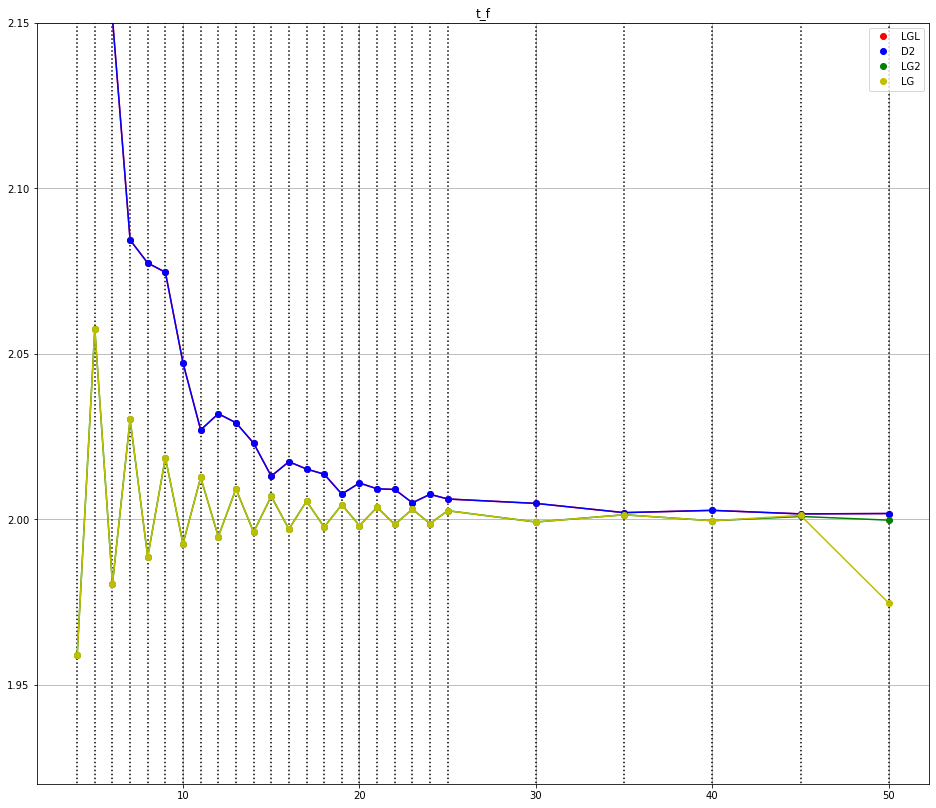

In [44]:
plt.figure(figsize=[16,14])

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
plt.title('t_f')
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['t_f'], color + 'o', label = scheme)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['t_f'], color)
plt.grid()
plt.legend()
plt.vlines(results_bloq['LGL']['N'], 1, 3, 'k',':')
plt.ylim([1.92,2.15])

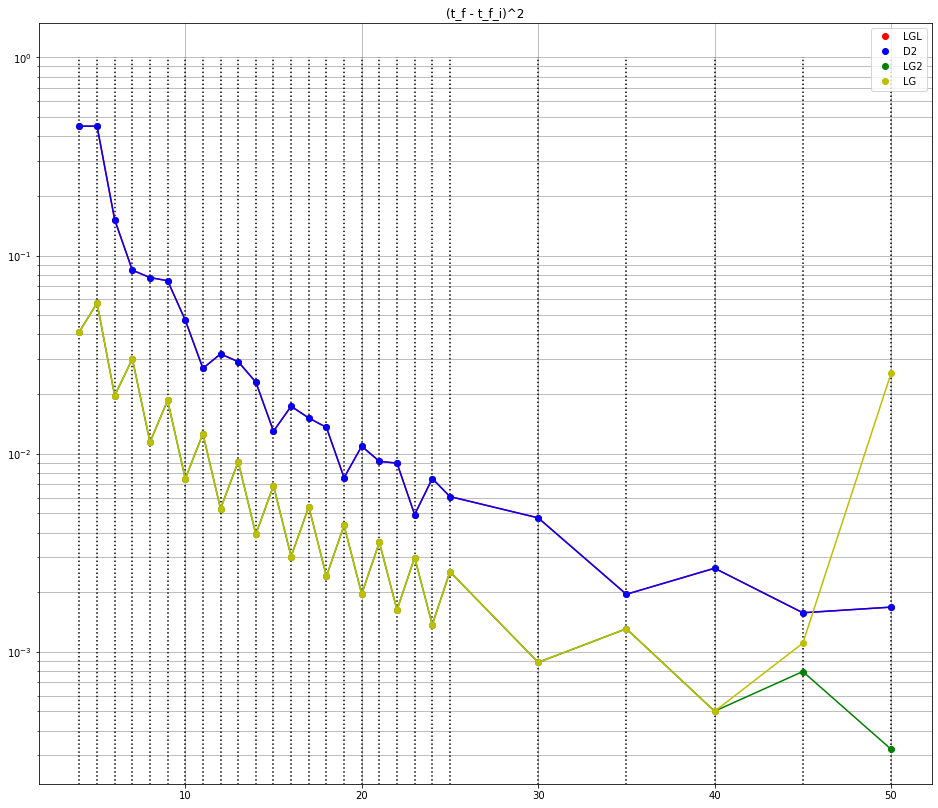

In [45]:
plt.figure(figsize=[16,14])

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
plt.title('(t_f - t_f_i)^2')
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], np.abs(np.array(results_bloq[scheme]['t_f'])-2), color + 'o', label = scheme)
    plt.plot(results_bloq[scheme]['N'], np.abs(np.array(results_bloq[scheme]['t_f'])-2), color)
plt.grid(which='both')
plt.legend()
plt.vlines(results_bloq['LGL']['N'], 0, 1, 'k',':')
#plt.ylim([-0.1,0.5])
plt.yscale('log')

Total errors LGL : 	 0
Total errors D2 : 	 0
Total errors LG2 : 	 0
Total errors LG : 	 0


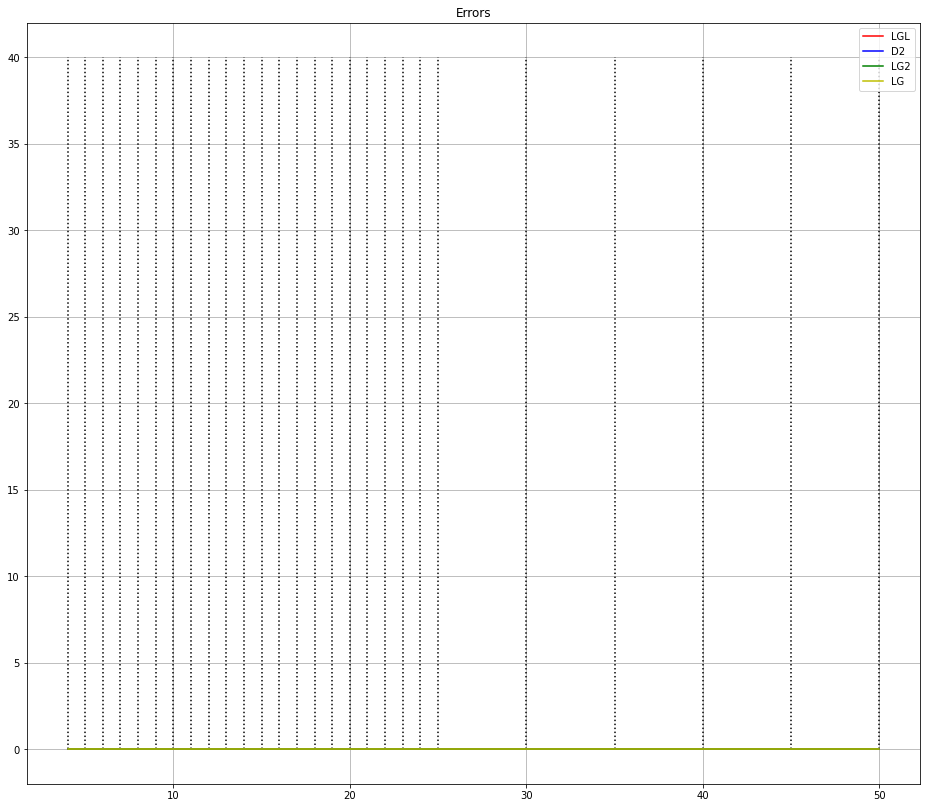

In [46]:
for scheme in schemes:
    print('Total errors', scheme, ': \t', np.sum(results_bloq[scheme]['err_count']))
plt.figure(figsize=[16,14])
plt.title('Errors')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['err_count'], color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_bloq['LGL']['N'], 0, 40, 'k',':')
#plt.yscale('log')

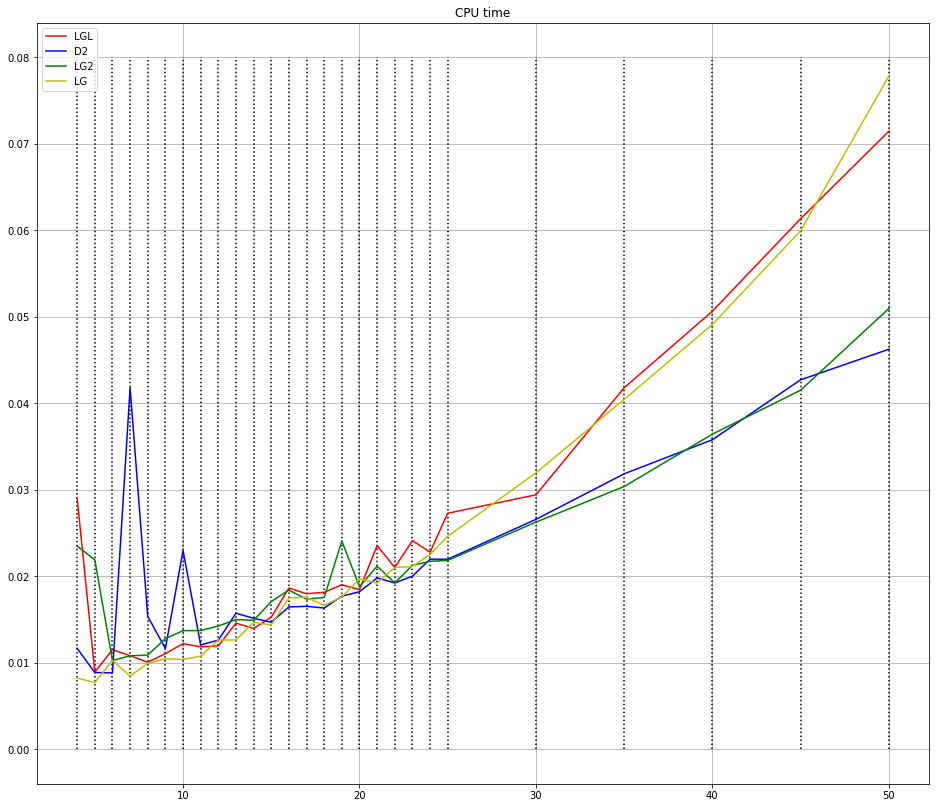

In [47]:
plt.figure(figsize=[16,14])

plt.title('CPU time')


schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['cpu_t'], color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_bloq['LGL']['N'], 0, 0.08, 'k',':')

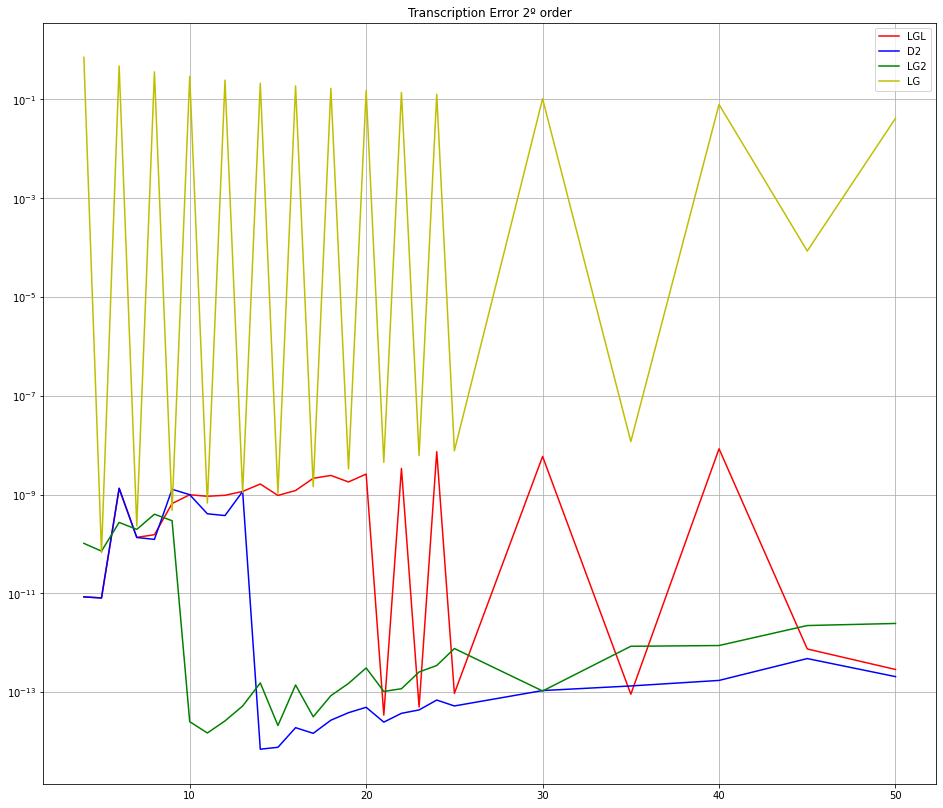

In [48]:
plt.figure(figsize=[16,14])

plt.title('Transcription Error 2º order')

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_2'], color, label = scheme)
plt.grid()
plt.legend()
plt.yscale('log')

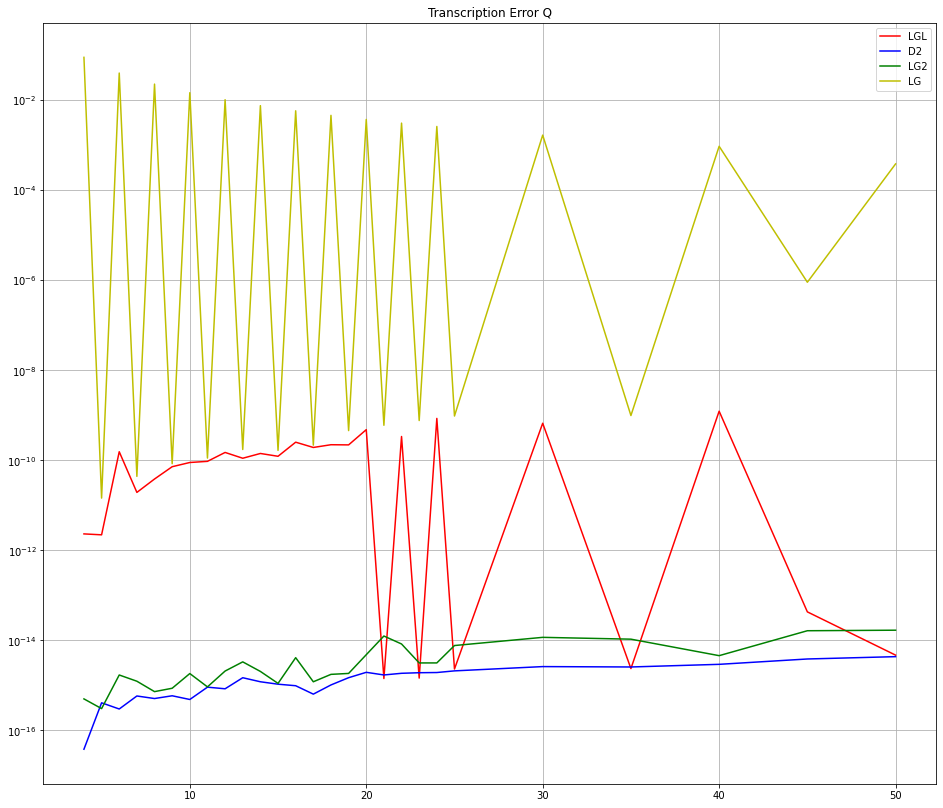

In [49]:
plt.figure(figsize=[16,14])

plt.title('Transcription Error Q')

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_q'], color, label = scheme)
plt.grid()
plt.legend()
plt.yscale('log')

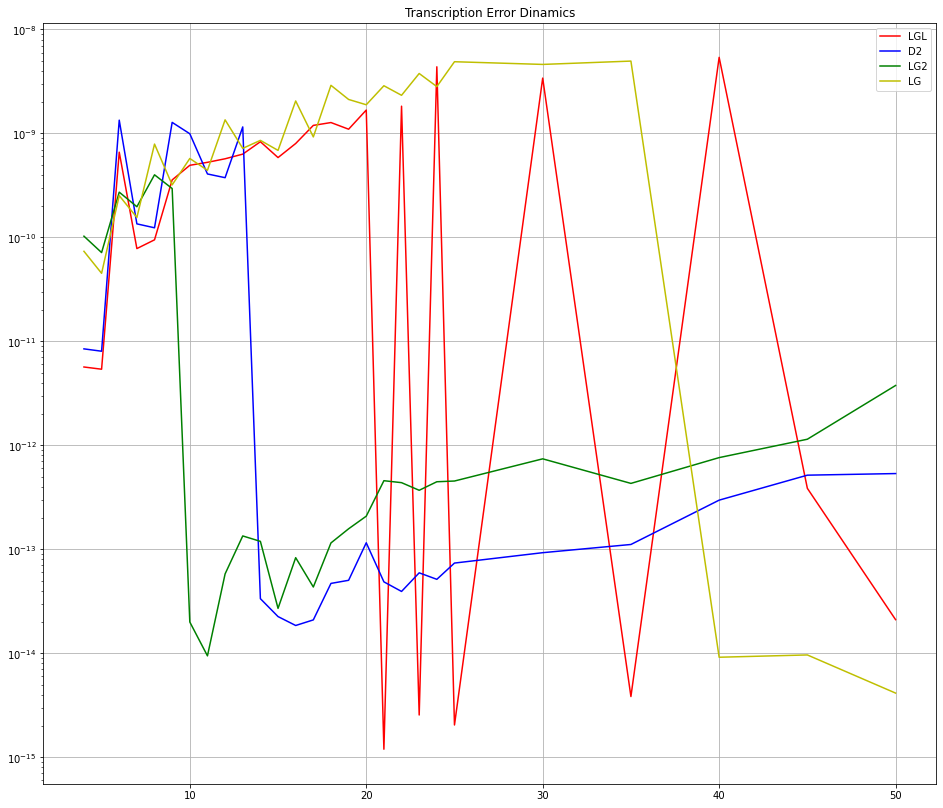

In [50]:
plt.figure(figsize=[16,14])

plt.title('Transcription Error Dinamics')

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_v'], color, label = scheme)
plt.grid()
plt.legend()
plt.yscale('log')

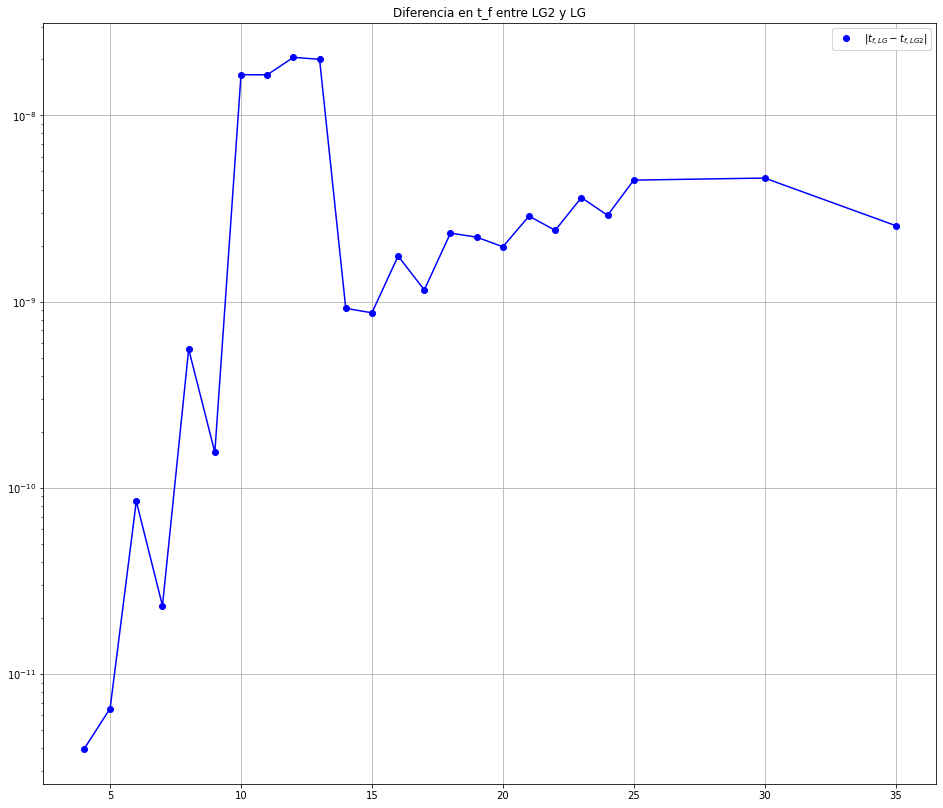

In [51]:
plt.figure(figsize=[16,14])

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
plt.title('Diferencia en t_f entre LG2 y LG')

scheme = schemes[ii]
color = colours[1]
plt.plot(results_bloq[scheme]['N'][:-3], np.abs(np.array(results_bloq['LG']['t_f'])[:-3]-np.array(results_bloq['LG2']['t_f'])[:-3]), color + 'o', label = '$|t_{f, LG}- t_{f, LG2}|$')
plt.plot(results_bloq[scheme]['N'][:-3], np.abs(np.array(results_bloq['LG']['t_f'])[:-3]-np.array(results_bloq['LG2']['t_f'])[:-3]), color)
plt.grid()
plt.legend()
#plt.vlines(results['LGL'][4], 1, 3, 'k',':')
#plt.ylim([1.92,2.15])
plt.yscale('log')

In [52]:
def poly_u(uu, scheme):
    N = len(uu)
    tau = coll_points(N, scheme, 30)
    return lagrangePolynomial(tau, uu)

In [53]:
def plot_u(uu, scheme, tf, color = 'k', t0 = 0, N_interp = 300):
    N = len(uu)
    tau = coll_points(N, scheme, 30)
    b_pol = bary_poly(tau, uu)
    coll_p_t = t_0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(coll_p_t, uu, color+'o', label = 'control '+scheme)
    #if N<=50:
    #    u_pol = lagrangePolynomial(tau, uu)
    #    u_interp_f = lambdify([x,],u_pol)
    #    plt.plot(t_int_arr, u_interp_f(tau_int_arr), color)
    #else:
    #    plt.plot(coll_p_t, uu, color+'--')
    plt.plot(t_int_arr, b_pol(tau_int_arr), color)

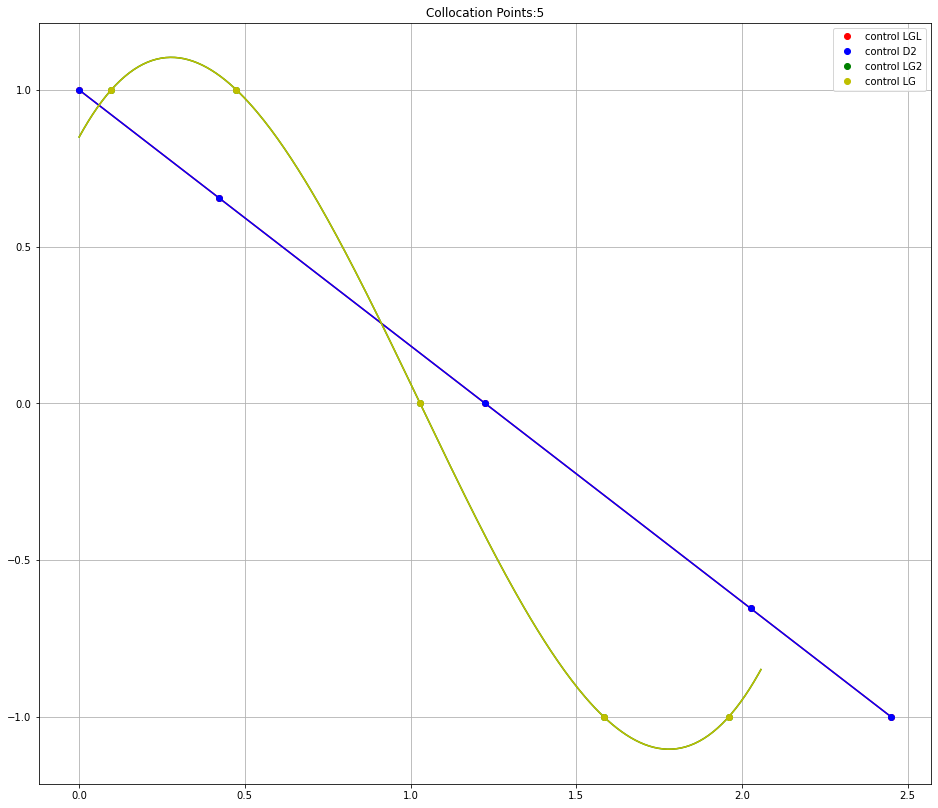

In [54]:

plt.figure(figsize=[16,14])
N_Problem = 1

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
plt.title('Collocation Points:' + str(results_bloq['LG2']['N'][N_Problem]))
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plot_u(
        results_bloq[scheme]['u'][N_Problem],
        scheme,
        results_bloq[scheme]['t_f'][N_Problem],
        color
    )
plt.grid()
plt.legend()

In [55]:
#for ii in range(len(results_bloq[scheme]['N'])):
for ii in range(5):
    _n = results_bloq[scheme]['N'][ii]
    print(f'\n\nN = {_n}')
    for scheme in schemes:
        _p_u = poly_u(
            results_bloq[scheme]['u'][ii],
            scheme
        )
        print(f'\n\t{scheme}')
        for jj in range(_n-1, _n-5, -1):
            print(f'x^{jj}: {"{:.1e}".format(float(_p_u.coeff(x**jj)))}\t', end='')
f'{"{:.2e}".format(_p_u.coeff(x**4))}'



N = 4

	LGL
x^3: -2.7e-16	x^2: -6.9e-16	x^1: -1.0e+00	x^0: 0.0e+00	
	D2
x^3: -1.2e-16	x^2: -2.1e-16	x^1: -1.0e+00	x^0: 0.0e+00	
	LG2
x^3: 2.8e+00	x^2: 2.7e-16	x^1: -3.3e+00	x^0: 0.0e+00	
	LG
x^3: 2.8e+00	x^2: 4.0e-11	x^1: -3.3e+00	x^0: 0.0e+00	

N = 5

	LGL
x^4: 1.5e-16	x^3: 1.4e-15	x^2: 1.9e-14	x^1: -1.0e+00	
	D2
x^4: -1.6e-17	x^3: -1.3e-15	x^2: -1.7e-16	x^1: -1.0e+00	
	LG2
x^4: 7.8e-15	x^3: 1.4e+00	x^2: -8.3e-15	x^1: -2.3e+00	
	LG
x^4: -3.9e-14	x^3: 1.4e+00	x^2: 3.5e-14	x^1: -2.3e+00	

N = 6

	LGL
x^5: 4.4e-15	x^4: 5.3e-15	x^3: 7.4e-01	x^2: 9.4e-15	
	D2
x^5: 1.4e-15	x^4: -9.8e-15	x^3: 7.4e-01	x^2: -3.5e-11	
	LG2
x^5: -7.4e+00	x^4: 1.5e-12	x^3: 1.1e+01	x^2: -1.7e-12	
	LG
x^5: -7.4e+00	x^4: -2.2e-10	x^3: 1.1e+01	x^2: 2.8e-10	

N = 7

	LGL
x^6: 2.8e-15	x^5: -2.3e-14	x^4: 2.8e-09	x^3: 2.0e+00	
	D2
x^6: -1.5e-15	x^5: 1.4e-14	x^4: 2.0e-15	x^3: 2.0e+00	
	LG2
x^6: 7.9e-13	x^5: -2.8e+00	x^4: -1.2e-12	x^3: 4.9e+00	
	LG
x^6: 1.4e-11	x^5: -2.8e+00	x^4: -2.4e-11	x^3: 4.9e+00	

N = 8

	LGL
x^7: 

'-1.10e-10'

In [56]:
def plot_q(qq, scheme, tf, color = 'k', t0 = 0, N_interp = 300):
    N = len(qq)
    tau = base_points(N, scheme, 30)
    int_p_t = t_0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(int_p_t, qq, color+'o', label = 'q '+scheme)
    if N<=50:
        q_pol = lagrangePolynomial(tau, qq)
        q_interp_f = lambdify([x,],q_pol)
        plt.plot(t_int_arr, q_interp_f(tau_int_arr), color)
    else:
        plt.plot(coll_p_t, qq, color+'--')
    return q_pol

LGL , len q: 6
D2 , len q: 6
LG2 , len q: 8
LG , len q: 7


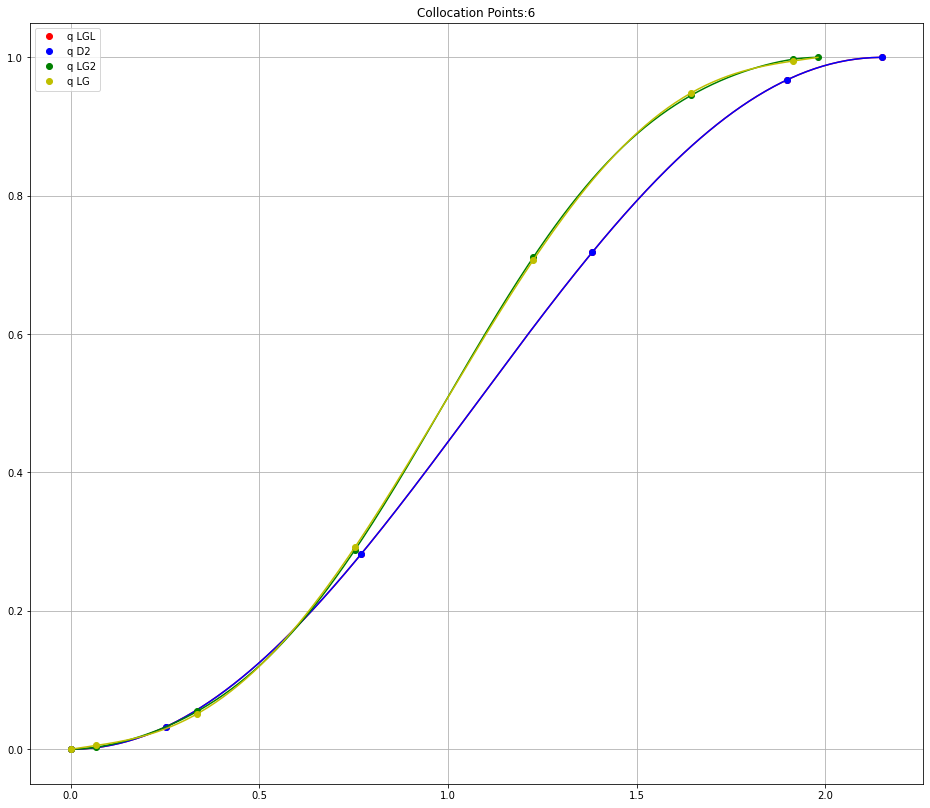

In [57]:

plt.figure(figsize=[16,14])
N_Problem = 2

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
plt.title('Collocation Points:' + str(results_bloq['LGL']['N'][N_Problem]))
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plot_q(
        results_bloq[scheme]['q'][N_Problem],
        scheme,
        results_bloq[scheme]['t_f'][N_Problem],
        color
    )
    print(scheme, ', len q:', len(results_bloq[scheme]['q'][N_Problem]))
plt.grid()
plt.legend()

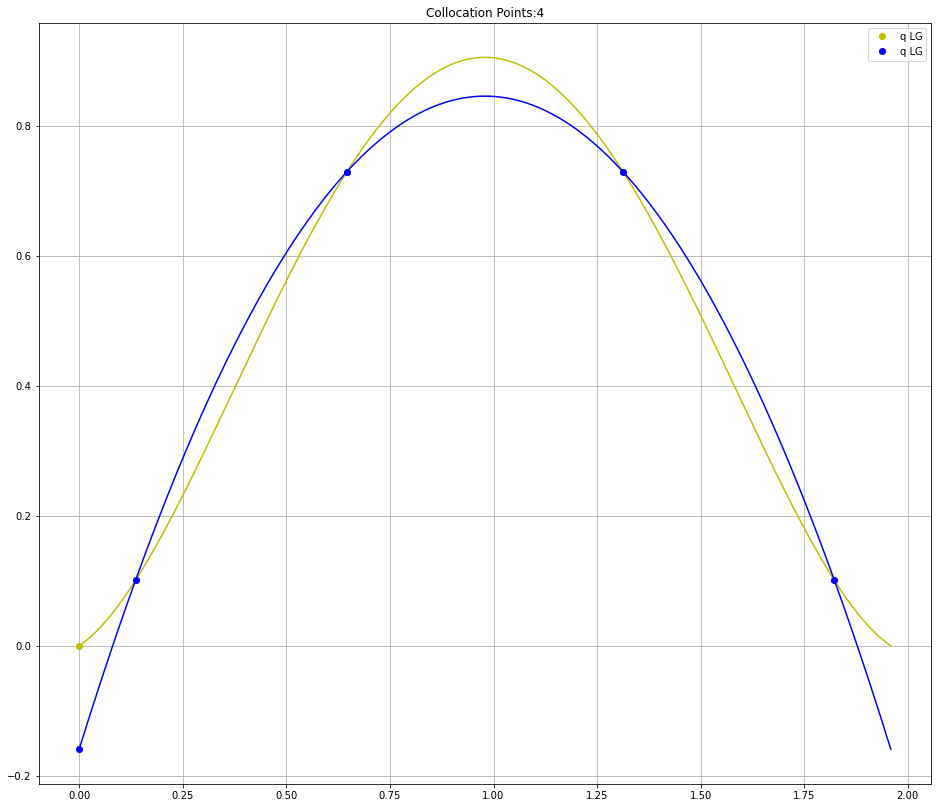

In [58]:

plt.figure(figsize=[16,14])
N_Problem = 0

schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
plt.title('Collocation Points:' + str(results_bloq['LGL']['N'][N_Problem]))
#for ii in range(5):
scheme = schemes[3]
_v_b = 2/(results_bloq[scheme]['t_f'][N_Problem]) *matrix_D_bary(results_bloq[scheme]['N'][N_Problem]+1, scheme,20) @ results_bloq[scheme]['q'][N_Problem]
_pol_1 = plot_q(
    results_bloq[scheme]['v'][N_Problem],
    scheme,
    results_bloq[scheme]['t_f'][N_Problem],
    color
)
_pol_2 = plot_q(
    _v_b,
    scheme,
    results_bloq[scheme]['t_f'][N_Problem],
    'b'
)
plt.grid()
plt.legend()

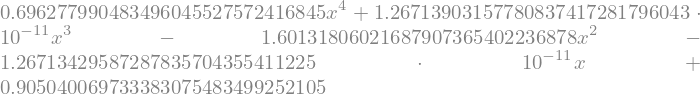

In [59]:
_pol_1

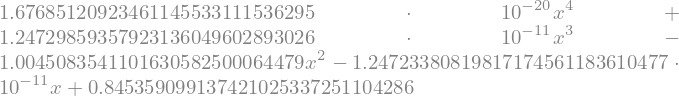

In [60]:
_pol_2

In [61]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_hsyi' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(dynamic_error_pseudospectral(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'Hermite')[2])
    
        results_bloq[scheme]['tr_err_hs'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_hs'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_hs'], color, label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_bloq['LGL']['N'], 10, 1e-3, 'k',':')

/opt/anaconda3/envs/siro/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fc47703a940> (for post_execute):


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Dinamics Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm',
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_d_hs' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'Hermite')[1])
        results_bloq[scheme]['tr_err_d_hs'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_d_hs'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_d_hs'], color, label = scheme, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_d_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'lin')[1])
        results_bloq[scheme]['tr_err_d_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_d_lin'], '--' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_v'], '--' + color)
    
plt.grid(which='both')
plt.legend()
plt.yscale('log')
#plt.ylim(0,0.2)
#plt.vlines(results['LGL'][4], 2, 2e-28, 'k',':')

results_bloq['LG'].pop('tr_err_u_lin')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for U Transcription Dynamics Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#, 'LGLm'
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_d_u_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'pol')[1])
        results_bloq[scheme]['tr_err_d_u_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_d_u_lin'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_d_u_lin'], color, label = scheme, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_d_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'lin')[1])
        results_bloq[scheme]['tr_err_d_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_d_lin'], '--' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_v'], '--' + color)
    
plt.grid(which='both')
plt.legend()
plt.yscale('log')
#plt.ylim(0, 0.2)
#plt.vlines(results['LGL'][4], 2, 2e-28, 'k',':')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for Q Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#, 'LGLm'
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_u_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'pol')[2])
        results_bloq[scheme]['tr_err_u_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_u_lin'], '--' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_q_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'pol',
                x_interp = 'lin')[2])
        results_bloq[scheme]['tr_err_q_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_q_lin'], 'o' + color, alpha = 1)
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_q_lin'], color, label = scheme, alpha = 1)

for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_bloq[scheme]['N']
    if not 'tr_err_lin' in results_bloq[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_bloq[scheme]['q'][jj],
                results_bloq[scheme]['v'][jj],
                results_bloq[scheme]['u'][jj],
                scheme,
                0.,
                results_bloq[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'lin')[2])
        results_bloq[scheme]['tr_err_lin'] = lite
    plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err_lin'], ':' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    #plt.plot(results_bloq[scheme]['N'], results_bloq[scheme]['tr_err'], '--' + color)
    
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.ylim(1e-4, 0.5)
#plt.vlines(results['LGL'][4], 2, 2e-28, 'k',':')

## Problema: Swing up del péndulo:

$$
\begin{split}\begin{array}{lc}
\begin{array}{l}
\text{minimize:} \\
x(\cdot) \in \mathbb{R}^2, \, u(\cdot) \in \mathbb{R}
\end{array}
\quad \displaystyle t_f
\\
\\
\text{subject to:} \\
\\
\begin{array}{ll}
\left\{
\begin{array}{l}
\dot{x}_0 = x_1 \\
\dot{x}_1 = u - sin(x_0) \\
-u_{max} \le u \le u_{max} , \quad
\end{array} \right. & \text{for} \, 0 \le t \le T \\
x_0(0)=0, \quad x_1(0)=0, x_0(T) = pi/2 , x_1(T) = 0
\end{array}
\end{array}\end{split}
$$
with $T=10$.

siendo $$x_0 = \theta$$ $$x_1 = \theta'$$

In [ ]:
@lru_cache
def obj_f_u_LGL_pend(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LGL(N, precission), coefs)
    res = integrate(cos(pol_lag), [x, -1, 1])
    return lambdify(coefs, res)

@lru_cache
def obj_f_u_LG2_pend(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG(N, precission), coefs)
    res = integrate(cos(pol_lag), [x, -1, 1])
    return lambdify(coefs, res)

In [ ]:
x_sym = cas.SX.sym('x', 2)
x_dot_sym = cas.SX.sym('x_dot', 2)
u_sym = cas.SX.sym('u',1)

dynam_f_x_pend = cas.Function(
    "dynamics_x",
    [x_sym, x_dot_sym, u_sym],
    [x_dot_sym[1]-(u_sym-cas.sin(x_sym[0]))]
)

In [ ]:
q_sym = cas.SX.sym('q', 1)
q_dot_sym = cas.SX.sym('q_dot', 1)
q_dot_dot_sym = cas.SX.sym('q_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f_q_pend = cas.Function(
    "dynamics_q",
    [q_sym, q_dot_sym, q_dot_dot_sym, u_sym],
    [q_dot_dot_sym-(u_sym - cas.sin(q_sym))]
)

In [ ]:
def plot_x(qq, scheme, tf, color = 'k', t0 = 0, N_interp = 300, label = 'q'):
    N = len(qq)
    tau = get_taus(N, scheme)
    b_pol = bary_poly(tau, qq)
    coll_p_t = t_0 + (1 + np.array(tau))*(tf - t0)/2
    tau_int_arr = np.linspace(-1, 1, N_interp)
    t_int_arr = np.linspace(t0, tf, N_interp)
    
    plt.plot(coll_p_t, qq, color+'o', label = label + ' ' +scheme)
    #if N<=50:
    #    q_pol = lagrangePolynomial(tau, qq)
    #    q_interp_f = lambdify([x,],q_pol)
    #    plt.plot(t_int_arr, q_interp_f(tau_int_arr), color)
    #else:
    #    plt.plot(coll_p_t, qq, color+'--')
    plt.plot(t_int_arr, b_pol(tau_int_arr), color)

In [ ]:
@lru_cache
def min_t_pend(col_points = 7, scheme = 'LGL', solve_repetitions = 20, precission = 20):
    
    opti, N, x_opti, u_opti, tau_arr = opti_setup(col_points, scheme, precission)
    
    t_f = opti.variable(1)
    t_0 = 0
    u_lim = opti.parameter(1)
    
    D_mat = sympy2casadi(matrix_D_bary(N-1, scheme,precission), [], [])
    x_dot_opti = 2/(t_f - t_0) * D_mat@x_opti
    x_dot_dot_opti = 2/(t_f - t_0) * D_mat@x_dot_opti

    cost = t_f
    opti.minimize(cost)
         
    opti.subject_to(t_f > 0)
    opti_start_point_constr(opti, scheme, x_opti, x_dot_opti, x_s = [0,0])
    opti_end_point_constr(opti, scheme, x_opti, x_dot_opti, N, x_f = [np.pi/2,0])
    opti_col_point_constr(opti, scheme, x_opti, x_dot_opti, x_dot_dot_opti, u_opti, 
                          dynam_f_x_pend, dynam_f_q_pend, N)
    
    for ii in range(col_points):
        opti.subject_to(u_opti[ii,:] <= u_lim[:])
        opti.subject_to(-u_lim[:] <= u_opti[ii,:])

    opti.set_value(u_lim, 0.5)
    opti.set_initial(t_f, 10.)
    
    #opti.set_initial(u_opti, list(np.linspace(-1,1,col_points)))
    
    sol, cpudt, err_count = chrono_solve_random_init(opti, solve_repetitions, u_opti, u_lim)
    
    t_f_sol = sol.value(t_f)
    
    qq_sol, vv_sol, uu_sol = opti_read_sol_arrays(scheme, sol, x_opti, u_opti, D_mat, t_f_sol)
        
    tran_err_q, tran_err_v, tran_err = error_transcr(qq_sol, vv_sol, uu_sol, scheme, t_0, t_f_sol,
                             u_interp='pol', x_interp='pol', problem='pend',)
    
    return t_f_sol, cpudt, uu_sol, qq_sol, vv_sol, tran_err_q, tran_err_v, tran_err, err_count

In [ ]:
if not 'results_pend' in globals():
    results_pend = {}
test_N = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,40,45,50]
#test_N = [6,7]#,8,9,10,11,12,13]
for scheme in ['LG','LGL', 'D2', 'LG2']:#,'LGLm'
    print(f'\n\t\t NUEVO ESQUEMA: {scheme}\n')
    
    t_f_list = []
    cpudt_list = []
    uu_sol_list = []
    qq_sol_list = []
    vv_sol_list = []
    tran_err_q_list = []
    tran_err_v_list = []
    tran_err_list = []
    err_count_list = []
    for N_col in test_N:
        print(f' Problema: {N_col} Collocation Points')
        time.sleep(0.01)
        t_f_sol, cpudt, uu_sol, qq_sol, vv_sol, tran_err_q, tran_err_v, tran_err, err_count = min_t_pend(col_points = N_col,
                                              scheme = scheme,
                                              solve_repetitions = 2000,
                                              precission = 20)
        t_f_list.append(t_f_sol)
        cpudt_list.append(cpudt)
        uu_sol_list.append(uu_sol)
        qq_sol_list.append(qq_sol)
        vv_sol_list.append(vv_sol)
        tran_err_q_list.append(tran_err_q)
        tran_err_v_list.append(tran_err_v)
        tran_err_list.append(tran_err)
        err_count_list.append(err_count)
    results_pend[scheme] = {
        't_f': t_f_list ,
        'cpu_t' : cpudt_list ,
        'u' : uu_sol_list,
        'N' : test_N,
        'q' : qq_sol_list,
        'v' : vv_sol_list,
        'tr_err_q' : tran_err_q_list,
        'tr_err_v' : tran_err_v_list,
        'tr_err' : tran_err_list,
        'err_count' : err_count_list,}

In [ ]:
plt.figure(figsize=[16,14])
N_Problem = -1
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
ii = 3
scheme = schemes[ii]
plt.title('Collocation Points:' + str(results_pend[scheme]['N'][N_Problem]) + ' ' + scheme)
color = colours[ii]
plot_u(
    results_pend[scheme]['u'][N_Problem],
    scheme,
    t_f_sol,
    'g',
    N_interp=1000
)
plot_x(
    results_pend[scheme]['q'][N_Problem],
    scheme,
    t_f_sol,
    'r'
)
plot_x(
    results_pend[scheme]['v'][N_Problem],
    scheme,
    t_f_sol,
    'b',
    label = 'v'
)
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=[16,14])


plt.title('t_f')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    quality = results_pend[scheme]['t_f']#[np.mean(np.cos(ii)) for ii in results_pend[scheme][4]]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], quality, color + 'o', label = scheme, alpha = 1)
    plt.plot(results_pend[scheme]['N'], quality, color, alpha = 1)
plt.grid()
plt.legend()
plt.vlines(results_pend['LGL']['N'], 4.7, 6, 'k',':')
#plt.ylim([1.92,2.15])

In [ ]:
#for ii in range(len(results_pend[scheme]['N'])):
for ii in range(5):
    _n = results_pend[scheme]['N'][ii]
    print(f'\n\nN = {_n}')
    for scheme in schemes:
        _p_u = poly_u(
            results_pend[scheme]['u'][ii],
            scheme
        )
        print(f'\n\t{scheme}')
        for jj in range(_n-1, _n-5, -1):
            print(f'x^{jj}: {"{:.1e}".format(float(_p_u.coeff(x**jj)))}\t', end='')
f'{"{:.2e}".format(_p_u.coeff(x**4))}'

In [ ]:

plt.figure(figsize=[16,14])
N_Problem = 0

plt.title('Collocation Points:' + str(test_N[N_Problem]))
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plot_u(
        results_pend[scheme]['u'][N_Problem],
        scheme,
        results_pend[scheme]['t_f'][N_Problem],
        color
    )
plt.grid()
plt.legend()

In [ ]:

plt.figure(figsize=[16,14])
N_Problem = 0

plt.title('Collocation Points:' + str(test_N[N_Problem]))
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plot_q(
        results_pend[scheme]['q'][N_Problem],
        scheme,
        results_pend[scheme]['t_f'][N_Problem],
        color
    )
    
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    #plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color, label = scheme, alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_q'], ':' + color, label = scheme + ' q', alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_v'], '-.' + color, label = scheme + ' d', alpha = 1)
plt.grid()
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1e-2, 1e-13, 'k',':')
plt.ylim(1e-13, 1e-2)

In [ ]:
solve_repetitions = 2000
for scheme in schemes:
    print('Runtime errors', scheme, ':', np.sum(results_pend[scheme]['err_count']), 'errores en', solve_repetitions, 'iteraciones')
plt.figure(figsize=[16,14])
plt.title('Error fraction')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], np.array(results_pend[scheme]['err_count'])/solve_repetitions, color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_pend['LGL']['N'], 0, 0.2, 'k',':')
#plt.yscale('log')

In [ ]:
plt.figure(figsize=[16,14])
plt.title('Casadi mean CPU time, random u init, 2000 runs')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['cpu_t'], color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_pend['LGL']['N'], 0, 0.22, 'k',':')
#plt.yscale('log')

In [ ]:
plt.figure(figsize=[16,14])
plt.title('CPU time')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['cpu_t'], color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_pend['LGL']['N'], 0, 0.22, 'k',':')
#plt.yscale('log')

In [ ]:
plt.figure(figsize=[16,14])
plt.title('CPU time')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['cpu_t'], color, label = scheme)
plt.grid()
plt.legend()
plt.vlines(results_pend['LGL']['N'], 0, 0.22, 'k',':')
#plt.yscale('log')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        #print('scheme: ', scheme, ' N: ', test_N[jj])
        lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'lin',
            problem='pend')[2])
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 1.4e-2, 'k',':')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        #print('scheme: ', scheme, ' N: ', test_N[jj])
        lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'lin',
            problem='pend')[2])
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 3e-13, 'k',':')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'Hermite',
            problem='pend')[2])
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 1e-3, 'k',':')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'Hermite',
            problem='pend')[2])
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'lin',
            problem='pend')[2])
    
    plt.plot(results_pend[scheme]['N'], lite, '--' + color, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 2e-13, 'k',':')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Hermite Interpolation Transcription Error with smoothed u')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'smooth',
            x_interp = 'Hermite',
            problem='pend')[2])
    
    plt.plot(results_pend[scheme]['N'], lite, 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], lite, color, label = scheme, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    lite = []
    test_N = results_pend[scheme]['N']
    for jj in range(len(test_N)):
        lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'Hermite',
            problem='pend')[2])
    
    plt.plot(results_pend[scheme]['N'], lite, ':' + color, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 2e-13, 'k',':')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for u Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#'LGLm', 
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    if not 'tr_err_u_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'pol',
            problem='pend')[2])
        results_pend[scheme]['tr_err_u_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_u_lin'], 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_u_lin'], color, label = scheme, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    
    if not 'tr_err_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
            results_pend[scheme]['q'][jj],
            results_pend[scheme]['v'][jj],
            results_pend[scheme]['u'][jj],
            scheme,
            0.,
            results_pend[scheme]['t_f'][jj],
            u_interp = 'lin',
            x_interp = 'lin',
            problem='pend')[2])
        results_pend[scheme]['tr_err_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_lin'], '--' + color, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 3e-13, 'k',':')

In [ ]:
plt.figure(figsize=[16,14])

plt.title('Lineal Interpolation for u Transcription Error')
schemes = ['LGL', 'D2', 'LG2', 'LG']#, 'LGLm'
colours = ['r', 'b', 'g', 'y', 'm']
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    if not 'tr_err_q_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                scheme,
                0.,
                results_pend[scheme]['t_f'][jj],
                u_interp = 'pol',
                x_interp = 'lin',
                problem='pend')[2])
        results_pend[scheme]['tr_err_q_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_q_lin'], 'o' + color, alpha = 1)
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_q_lin'], color, label = scheme, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    if not 'tr_err_u_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            #print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                scheme,
                0.,
                results_pend[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'pol',
                problem='pend')[2])
        results_pend[scheme]['tr_err_u_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_u_lin'], '-.' + color, alpha = 1)
    
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    test_N = results_pend[scheme]['N']
    
    if not 'tr_err_lin' in results_pend[scheme].keys():
        lite = []
        for jj in range(len(test_N)):
            print('scheme: ', scheme, ' N: ', test_N[jj])
            lite.append(error_transcr(
                results_pend[scheme]['q'][jj],
                results_pend[scheme]['v'][jj],
                results_pend[scheme]['u'][jj],
                scheme,
                0.,
                results_pend[scheme]['t_f'][jj],
                u_interp = 'lin',
                x_interp = 'lin',
                problem='pend')[2])
        results_pend[scheme]['tr_err_lin'] = lite
    
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err_lin'], ':' + color, alpha = 1)
for ii in range(len(schemes)):
    scheme = schemes[ii]
    color = colours[ii]
    plt.plot(results_pend[scheme]['N'], results_pend[scheme]['tr_err'], color + '--', alpha = 1)
plt.grid(which='both')
plt.legend()
plt.yscale('log')
plt.vlines(results_pend['LGL']['N'], 1, 3e-13, 'k',':')